## Example 4 - `stripy` gradients

SRFPACK is a Fortran 77 software package that constructs a smooth interpolatory or approximating surface to data values associated with arbitrarily distributed points. It employs automatically selected tension factors to preserve shape properties of the data and avoid overshoot and undershoot associated with steep gradients.

#### Notebook contents

   - [Analytic function and derivatives](#Analytic-function)
   - [Evaluating accuracy](#Derivatives-of-solution-compared-to-analytic-values)


The next example is [Ex5-Smoothing](./Ex5-Smoothing.ipynb)

### Define a computational mesh

Use the (usual) icosahedron with face points included.

In [1]:
import stripy as stripy

xmin = 0.0
xmax = 10.0
ymin = 0.0
ymax = 10.0
extent = [xmin, xmax, ymin, ymax]

spacingX = 0.2
spacingY = 0.2

mesh = stripy.cartesian_meshes.elliptical_mesh(extent, spacingX, spacingY, refinement_levels=3)
mesh = stripy.Triangulation(mesh.x, mesh.y, permute=True)

print("number of points = {}".format(mesh.npoints))

number of points = 15496


### Analytic function 

Define a relatively smooth function that we can interpolate from the coarse mesh to the fine mesh and analyse

In [2]:
import numpy as np

def analytic(xs, ys, k1, k2):
     return np.cos(k1*xs) * np.sin(k2*ys)

def analytic_ddx(xs, ys, k1, k2):
     return -k1 * np.sin(k1*xs) * np.sin(k2*ys) / np.cos(ys)

def analytic_ddy(xs, ys, k1, k2):
     return k2 * np.cos(k1*xs) * np.cos(k2*ys) 

analytic_sol = analytic(mesh.x, mesh.y, 0.1, 1.0)
analytic_sol_ddx = analytic_ddx(mesh.x, mesh.y, 0.1, 1.0)
analytic_sol_ddy = analytic_ddy(mesh.x, mesh.y, 0.1, 1.0)

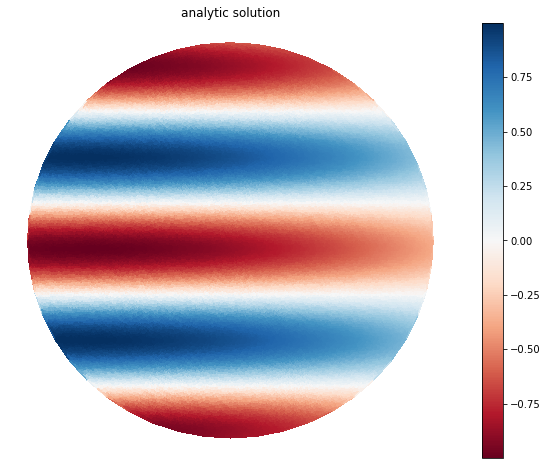

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def axis_mesh_field(fig, ax, mesh, field, label):

    ax.axis('off')

    x0 = mesh.x
    y0 = mesh.y
    
    trip = ax.tripcolor(x0, y0, mesh.simplices, field, cmap=plt.cm.RdBu)
    fig.colorbar(trip, ax=ax)
    
    ax.set_title(str(label))
    return

    
fig = plt.figure(figsize=(10, 8), facecolor="none")
ax = fig.add_subplot(111)
axis_mesh_field(fig, ax, mesh, analytic_sol, "analytic solution")

### Derivatives of solution compared to analytic values

The `gradient` method of `Triangulation` takes a data array f representing values on the mesh vertices and returns the x,y derivatives.

``` python
Triangulation.gradient(f, nit=3, tol=0.001)

```

Derivatives of higher accuracy can be obtained by tweaking `tol`, which controls the convergence tolerance, or `nit` which controls the number of iterations to a solution. The default values are set to an optimal trade-off between speed and accuracy.

In [4]:
stripy_ddx, stripy_ddy = mesh.gradient(analytic_sol)
stripy_d2x, _ = mesh.gradient(stripy_ddx)
_, stripy_d2y = mesh.gradient(stripy_ddy)

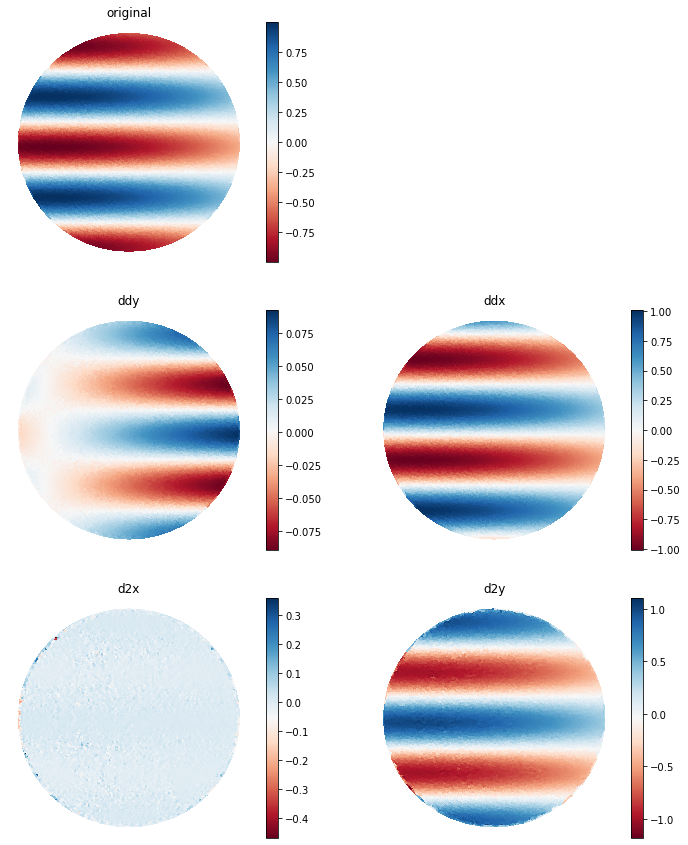

In [5]:
fig, ax = plt.subplots(3,2, figsize=(12, 15), facecolor="none")

axis_mesh_field(fig, ax[0,0], mesh, analytic_sol, label="original")
axis_mesh_field(fig, ax[1,0], mesh, stripy_ddx, label="ddy")
axis_mesh_field(fig, ax[1,1], mesh, stripy_ddy, label="ddx")
axis_mesh_field(fig, ax[2,0], mesh, stripy_d2x, label="d2x")
axis_mesh_field(fig, ax[2,1], mesh, stripy_d2y, label="d2y")

ax[0,1].axis('off')

plt.show()

In [6]:
from stripy import _srfpack
def second_gradient_local(self, f, index):
    """
    Return the gradient / 2nd partials of an n-dimensional array.

    The method consists of minimizing a quadratic functional Q(G) over
    gradient vectors (in x and y directions), where Q is an approximation
    to the linearized curvature over the triangulation of a C-1 bivariate
    function \\(F(x,y)\\) which interpolates the nodal values and gradients.

    Args:
        f : array of floats, shape (n,)
            field over which to evaluate the gradient
        nit : int (default: 3)
            number of iterations to reach a convergence tolerance,
            tol nit >= 1
        tol: float (default: 1e-3)
            maximum change in gradient between iterations.
            convergence is reached when this condition is met.

    Returns:
        dfdx : array of floats, shape (n,)
            derivative of f in the x direction
        dfdy : array of floats, shape (n,)
            derivative of f in the y direction

    Notes:
        For SIGMA = 0, optimal efficiency was achieved in testing with
        tol = 0, and nit = 3 or 4.

        The restriction of F to an arc of the triangulation is taken to be
        the Hermite interpolatory tension spline defined by the data values
        and tangential gradient components at the endpoints of the arc, and
        Q is the sum over the triangulation arcs, excluding interior
        constraint arcs, of the linearized curvatures of F along the arcs --
        the integrals over the arcs of \\( (d^2 F / dT^2)^2\\), where \\( d^2 F / dT^2\\)is the second
        derivative of \\(F\\) with respect to distance \\(T\\) along the arc.
    """

    if f.size != self.npoints:
        raise ValueError('f should be the same size as mesh')

    sigma = self.sigma
    iflgs = self.iflgs

    f = self._shuffle_field(f)
    index = self._shuffle_simplices(index)

    ## wrapping: 

    # subroutine gradc(k,ncc,lcc,n,x,y,z,list,lptr,lend,dx,dy,dxx,dxy,dyy,ier) ! in :_srfpack:srfpack.f
    # subroutine gradg(  ncc,lcc,n,x,y,z,list,lptr,lend,iflgs,sigma,nit,dgmax,grad,ier) ! in :_srfpack:srfpack.f

    dx, dy, dxx, dxy, dyy, ierr = _srfpack.gradcs(index+1, self._x, self._y, f, self.lst, self.lptr, self.lend)

    if ierr < 0:
        raise ValueError('ierr={} in gradc\n{}'.format(ierr, _ier_codes[ierr]))

    return dx, dy, dxx, dxy, dyy


In [7]:
def gradient_local(self, f, index):
    """
    Return the gradient at a specified node.

    This routine employs a local method, in which values depend only on nearby
    data points, to compute an estimated gradient at a node.

    `gradient_local()` is more efficient than `gradient()` only if it is unnecessary
    to compute gradients at all of the nodes. Both routines have similar accuracy.
    """
    if f.size != self.npoints:
        raise ValueError('f should be the same size as mesh')

    f = self._shuffle_field(f)
    index = self._shuffle_simplices(index)

    gradX, gradY, l = _srfpack.gradls(index + 1, self._x, self._y, f,\
                                     self.lst, self.lptr, self.lend)

    return gradX, gradY

In [8]:
indices = np.arange(0, mesh.npoints)

dx, dy = gradient_local(mesh, analytic_sol, indices)

In [9]:
stripy_ddy.shape, dx.shape

((15496,), (15496,))

(0.0, 1.0, 0.0, 1.0)

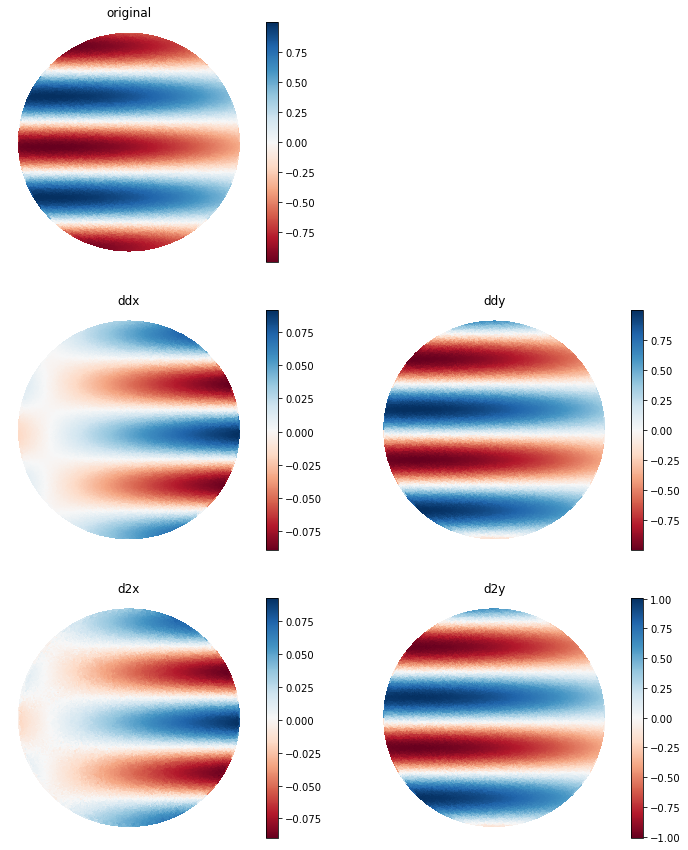

In [10]:
fig, ax = plt.subplots(3,2, figsize=(12, 15), facecolor="none")

axis_mesh_field(fig, ax[0,0], mesh, analytic_sol, label="original")
axis_mesh_field(fig, ax[1,0], mesh, dx, label="ddx")
axis_mesh_field(fig, ax[1,1], mesh, dy, label="ddy")
axis_mesh_field(fig, ax[2,0], mesh, stripy_ddx, label="d2x")
axis_mesh_field(fig, ax[2,1], mesh, stripy_ddy, label="d2y")

ax[0,1].axis('off')

In [11]:
indices = np.arange(0, mesh.npoints)
dx, dy, dxx, dxy, dyy = second_gradient_local(mesh, analytic_sol, indices)

AttributeError: 'Triangulation' object has no attribute 'sigma'

In [12]:
d2x = np.zeros_like(stripy_d2x)
d2y = np.zeros_like(stripy_d2y)
d1x = np.zeros_like(stripy_d2y)
d1y = np.zeros_like(stripy_d2y)
for index in range(0, mesh.npoints):
    dx, dy, dxx, dxy, dyy = second_gradient_local(mesh, analytic_sol, index)
    d2x[index] = dxx
    d2y[index] = dyy
    d1x[index] = dx
    d1y[index] = dy

AttributeError: 'Triangulation' object has no attribute 'sigma'

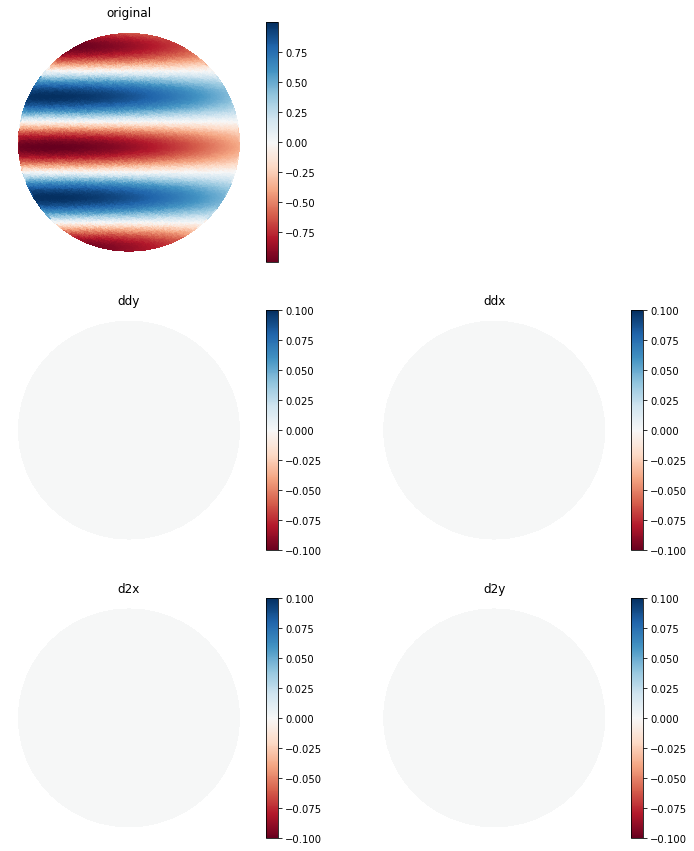

In [13]:
fig, ax = plt.subplots(3,2, figsize=(12, 15), facecolor="none")

axis_mesh_field(fig, ax[0,0], mesh, analytic_sol, label="original")
axis_mesh_field(fig, ax[1,0], mesh, d1x, label="ddy")
axis_mesh_field(fig, ax[1,1], mesh, d1y, label="ddx")
axis_mesh_field(fig, ax[2,0], mesh, d2x, label="d2x")
axis_mesh_field(fig, ax[2,1], mesh, d2y, label="d2y")

ax[0,1].axis('off')

plt.show()

The next example is [Ex5-Smoothing](./Ex5-Smoothing.ipynb)

In [14]:
dsdx, dsdy = mesh.gradient(analytic_sol)
print(dsdx[0], dsdy[0])

s, (dsdx, dsdy), err = mesh.smoothing(analytic_sol, np.ones_like(analytic_sol), 10.0, 0.8, 0.00001)
print(dsdx[0], dsdy[0])

0.0471135 0.24565278


0.048810177 0.24498941


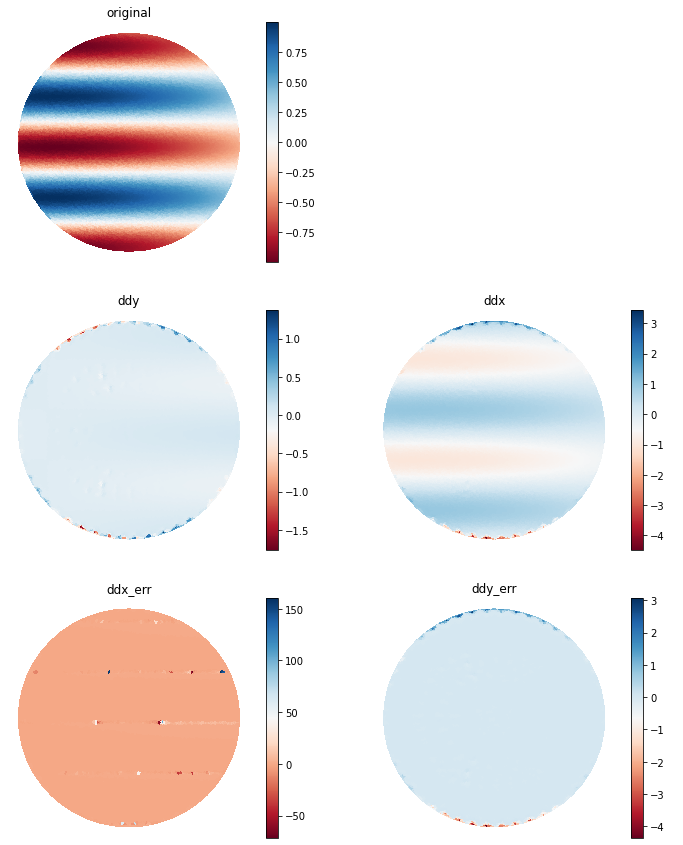

In [15]:
fig, ax = plt.subplots(3,2, figsize=(12, 15), facecolor="none")

axis_mesh_field(fig, ax[0,0], mesh, analytic_sol, label="original")
axis_mesh_field(fig, ax[1,0], mesh, dsdx, label="ddy")
axis_mesh_field(fig, ax[1,1], mesh, dsdy, label="ddx")
axis_mesh_field(fig, ax[2,0], mesh, dsdx-analytic_sol_ddx, label="ddx_err")
axis_mesh_field(fig, ax[2,1], mesh, dsdy-analytic_sol_ddy, label="ddy_err")

ax[0,1].axis('off')

plt.show()

The next notebook is [Ex5-Smoothing](./Ex5-Smoothing.ipynb)